In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

In [2]:
PATH='data/sentiment140/'

TRN_PATH = 'train/'
VAL_PATH = 'test/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
os.makedirs(TRN, exist_ok=True)
os.makedirs(VAL, exist_ok=True)
%ls {TRN}

train2_sentiment140.csv*


In [3]:
!ls {PATH}

models				Sentiment-Analysis-Dataset.zip	tmp
Sentiment-Analysis-Dataset.csv	test				train


In [3]:
TEXT = data.Field(lower=True, tokenize=spacy_tok) # word-level

In [3]:
TEXT = data.Field(lower=True, tokenize=list) # character-level: list('abc') = ['a', 'b', 'c']

In [4]:
bs=32; bptt=70

In [6]:
df = pd.read_csv(f'{PATH}Sentiment-Analysis-Dataset.csv', skiprows=lambda x: x in [8835, 535881])

In [7]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [5]:
n = len(df)

NameError: name 'df' is not defined

In [9]:
idxs = get_cv_idxs(n)
val_df = df.iloc[idxs].set_index("ItemID")
samp_size = len(val_df); samp_size

315722

In [10]:
df.to_csv(f'{PATH}train/train2_sentiment140.csv')
val_df.to_csv(f'{PATH}test/test2_sentiment140.csv')

In [7]:
df = pd.read_csv(f'{PATH}train/train2_sentiment140.csv')
val_df = pd.read_csv(f'{PATH}test/test2_sentiment140.csv')

In [8]:
md = LanguageModelData.from_dataframes(PATH, TEXT, 'SentimentText', df, val_df, test_df=val_df, bs=bs, bptt=bptt, min_freq=10)

In [12]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT_CHAR_TOKEN.pkl','wb'))

In [9]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(57525, 153, 1, 128859390)

In [11]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ' ', 'e', 'o', 't', 'a', 's', 'i', 'n', 'r', 'h']

In [12]:
TEXT.vocab.stoi['a']

6

In [13]:
md.trn_ds[0].text[:12]

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [11]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
 35979
    15
    27
   133
    19
    11
     0
   268
  6624
     3
 33805
     4
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [12]:
next(iter(md.trn_dl))

(Variable containing:
  35979     28     21  ...      23    758      3
     15     86    120  ...      53      2      0
     27      4     56  ...       7      3     55
         ...            ⋱           ...         
   8407    419     84  ...     148      2    251
    125    161   2648  ...      34      3      3
      4  10451   3724  ...     618     31    168
 [torch.cuda.LongTensor of size 81x32 (GPU 0)], Variable containing:
     15
     86
    120
   ⋮   
     36
    450
     17
 [torch.cuda.LongTensor of size 2592 (GPU 0)])

In [10]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [11]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [12]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.2, dropout=0.2, wdrop=0.1, dropoute=0.08, dropouth=0.2)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [21]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      1.463729   1.344674  
    1      1.380259   1.368818                                  
    2      1.378212   1.310305                                  
    3      1.387688   1.383124                                  
    4      1.369171   1.347126                                  
    5      1.321014   1.326489                                    
    6      1.350098   1.308905                                    
    7      1.382018   1.410311                                    
    8      1.369153   1.378009                                    
    9      1.361054   1.352548                                    
    10     1.344597   1.354824                                    
    11     1.335721   1.33966                                     
    12     1.331679   1.321919                                    
    13     1.327359   1.311371                                    
    14     1.32672    1.318314         

[1.3183138]

In [22]:
learner.save_encoder('dropout_exp_1_adam3_10_enc')

In [13]:
learner.load_encoder('dropout_exp_1_adam3_10_enc')

In [23]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 44598/57525 [1:06:09<19:10, 11.23it/s, loss=5.12]

 78%|███████▊  | 44598/57525 [1:15:11<21:47,  9.89it/s, loss=5.12]

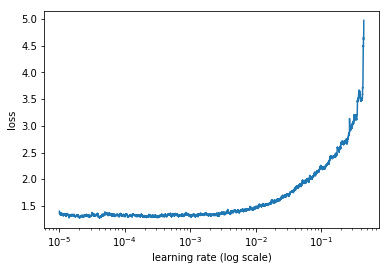

In [24]:
learner.sched.plot()

In [ ]:
learner.fit([3e-5, 3e-4, 3e-3], 1, wds=1e-6, cycle_len=10, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  0%|          | 65/57525 [00:05<1:19:25, 12.06it/s, loss=1.35]

Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                    
    0      1.318134   1.315782  
    1      1.32731    1.316419                                    
    2      1.321593   1.316842                                    
    3      1.330452   1.317076                                    
    4      1.30788    1.317535                                    
    5      1.316006   1.319693                                    
 84%|████████▍ | 48349/57525 [54:08<10:16, 14.88it/s, loss=1.32] 

In [49]:
learner.save_encoder('dropout_exp_2_adam3_10_enc')

In [52]:
learner.fit(3e-3, 2, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

[ 0.       4.55263  4.57914]                                    
[ 1.       4.63134  4.67246]                                    
[ 2.       4.63319  4.66507]                                    
[ 3.       4.65825  4.65508]                                    
[ 4.       4.64992  4.65094]                                    
[ 5.       4.64433  4.64873]                                    
[ 6.       4.64174  4.63384]                                    
[ 7.       4.58426  4.63529]                                    
[ 8.       4.60742  4.62555]                                    
[ 9.       4.59639  4.62434]                                    
[ 10.        4.584     4.61225]                                 
[ 11.        4.57332   4.60437]                                 
[ 12.        4.55848   4.58865]                                 
[ 13.        4.52542   4.58274]                                 
[ 14.        4.56124   4.57546]                                 
[ 15.        4.54774   4.

In [70]:
learner.save_encoder('dropout_exp_3_adam3_10_enc')

In [100]:
learner.save('dropout_exp_3_adam3_20_model')

In [20]:
learner.load('dropout_exp_3_adam3_20_model')

RuntimeError: While copying the parameter named 0.encoder.weight, whose dimensions in the model are torch.Size([153, 200]) and whose dimensions in the checkpoint are torch.Size([44587, 200]).

In [95]:
m=learner.model
ss="""omg my life is """
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'omg my life is'

In [96]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [97]:
nexts = torch.topk(res[-1], 20)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['so',
 'over',
 '<unk>',
 'not',
 'a',
 'going',
 'really',
 'just',
 'almost',
 'too',
 "n't",
 'the',
 'like',
 'good',
 'sooo',
 'boring',
 'gon',
 'always',
 'soo',
 'killing']

In [98]:
print(ss,"\n")
for i in range(25):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

omg my life is  

so boring   i 'm so sad . i 'm so sad . i 'm so sad . i 'm so sad . i 'm ...


In [99]:
m

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(44587, 200, padding_idx=1)
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(200, 500, dropout=0.2)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500, dropout=0.2)
      )
      (2): WeightDrop(
        (module): LSTM(500, 200, dropout=0.2)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouth): LockedDropout(
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=200, out_features=44587)
    (dropout): LockedDropout(
    )
  )
)

In [8]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [14]:
SENTIMENT_LABEL = data.Field(sequential=False)

In [89]:
??LanguageModelData.from_dataframes

In [35]:
??ConcatTextDatasetFromDataFrames.splits

In [41]:
torchtext.datasets.IMDB.splits

<bound method IMDB.splits of <class 'torchtext.datasets.imdb.IMDB'>>

In [40]:
md.trn_ds.splits

<bound method ConcatTextDatasetFromDataFrames.splits of <class 'fastai.nlp.ConcatTextDatasetFromDataFrames'>>

In [10]:
class Sentiment140Dataset(torchtext.data.TabularDataset):
    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, **kwargs):
        train_data = None if train_df is None else cls(train_df, **kwargs)
        val_data = None if val_df is None else cls(val_df, **kwargs)
        test_data = None if test_df is None else cls(test_df, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

In [15]:
class Sentiment140Dataset(torchtext.data.Dataset):
    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('sentiment', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = 'pos'
            if not is_test and row['Sentiment']==0:
                label = 'neg' 
            text = row['SentimentText']
            examples.append(torchtext.data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [102]:
ls {PATH}

models/               Sentiment-Analysis-Dataset.csv*  test/  train/
sentiment140.tar.xz*  Sentiment-Analysis-Dataset.zip*  tmp/


In [ ]:
ds = Sentiment140Dataset.splits(df, TEXT, SENTIMENT_LABEL)

In [13]:
ds.examples

 ...]